# $\chi^2$ squared likelihood for the database

Calculating the chi squared likelihood for luminosity functions for the database of 21cmFASTv4 https://github.com/nikos-triantafyllou/Database-21cmFASTv4/tree/main <br>
**Author:** Nikolaos (Nikos) Triantafyllou<br>
**Date:** March 2025

---


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import py21cmfast_tools as p21c_tools
import py21cmfast as p21c
import os

plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})
plt.rcParams['lines.linewidth'] = plt.rcParamsDefault['lines.linewidth']

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

import powerbox as pbox
from importlib import reload
import n_plotting
import d_plotting
import d_get_properties
import d_utils
from useful_functions.get_bardeen_PS import power_21c

EoR_color already loaded
EoR_color already loaded


In [2]:
# Load the file
# hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/id_1091.h5', 'r')
hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_21.h5', 'r')


# And let's see some general information
dict(hdf.attrs)

{'21cmFAST_version': '3.4.1.dev523+g33e40a87',
 'creation date/time': '2025-03-03 19:19:18.802690',
 'python_version': '3.11.6',
 'random_seed': 23,
 'redshift': 5}

## Observed UVLFs Daniela

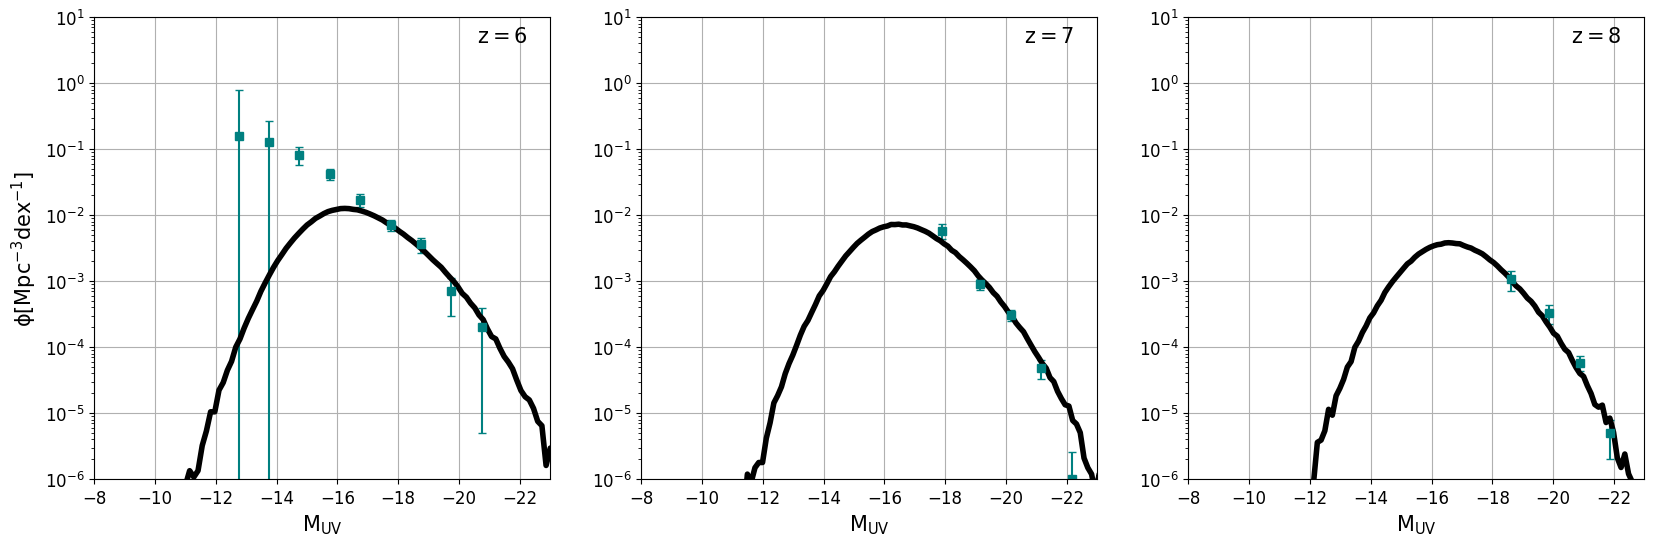

In [76]:
## UV LF ##
Muv_limits = [-23, -8]
fig, axsLF = plt.subplots(nrows = 1, ncols=3, figsize = (20,6))
for qq, redshift in enumerate([6,7,8]):
    fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(redshift)

    datainput = np.loadtxt(fLF)
    axsLF[qq].errorbar(datainput[::2,0], (datainput[::2,1]), yerr=datainput[::2,2], color='teal',fmt='s',zorder=2, capsize=3, label = 'HST observations')
    
    
    Muv, phi = d_utils.get_uvlf(redshift, hdf)
    axsLF[qq].plot(Muv, phi, color='black', linewidth =4, label = '21cmFAST')
    
    
    
    axsLF[qq].text(0.95,0.98, fr'$ \rm z={redshift} $', horizontalalignment='right',\
                  verticalalignment='top',transform=axsLF[qq].transAxes,fontsize=15)

    axsLF[qq].set_xlim(Muv_limits[::-1])
    axsLF[qq].set_ylim(1e-6,10)
    axsLF[qq].set_yscale('log')
    axsLF[qq].set_xlabel(r'$\rm M_{\rm UV}$',fontsize=15)
    axsLF[qq].xaxis.set_tick_params(labelsize=12)
    axsLF[qq].grid()


axsLF[0].set_ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$",fontsize=15);



# Yuxiang's EoR history

In [4]:
yxg_eor_z_arr =   [5.0, 5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0,  10.5,  11.0,  11.5,  12.0,  12.5,  13.0,  13.5, 14.0]
yxg_eor_xhi_arr = [0.0, 0.02, 0.1, 0.24, 0.38, 0.45, 0.57, 0.65, 0.73, 0.79, 0.82,  0.89,  0.91,  0.93,  0.96,  0.98,  0.99,  0.99,  1.0]

Coeval quantity shape: (92,)
Node redshifts shape: (92,)


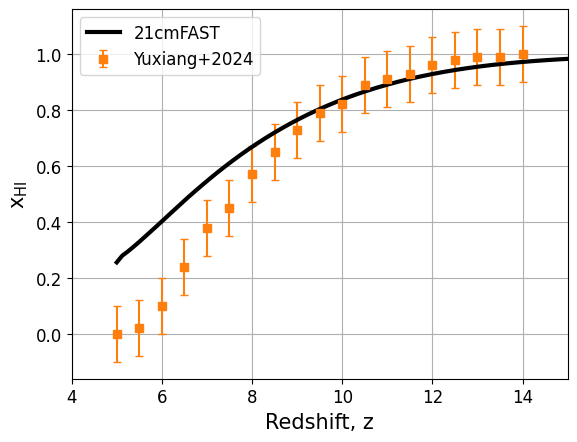

In [5]:
# Let's get the neutral fraction
x_HI_coev = hdf['coeval_data']['x_HI'][:]
print('Coeval quantity shape:', x_HI_coev.shape)

# And the redshifts corresponding to the 92 values of the previus array
node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']
print('Node redshifts shape:', node_redshifts.shape)

# Let's plot it!
fig, ax = plt.subplots()
ax.errorbar(yxg_eor_z_arr,yxg_eor_xhi_arr, yerr = 0.1, fmt='s', capsize=3, color='tab:orange', label= 'Yuxiang+2024')
ax.plot(node_redshifts, x_HI_coev, color='black', label='21cmFAST', linewidth = 3)
ax.set_xlabel('Redshift, z')
ax.set_ylabel(r'$\rm x_{HI}$')
plt.grid()


ax.set_xlim([4,15])

ax.legend()
plt.show()

---
(Note: be carreful of the difference between $\chi$ and $x$)


We want to take a $\chi^2$ effective likelihood to make our parameters match the observations. <br>
What this means is that we have a quantity, a metric, that we want to minimize, in this case $\chi^2$.<br>

Let's say we only have run 1 simulation.
We want to compare our data $y_i$ (with errors $\sigma_i$), with our model predictions $f_i(\{x\})$, where $\{x\}$ our parameter set of the simulation. We have the following expression:
    
$$ \chi^2 = \sum_i \frac{(y_i - f_i(\{x\}))^2}{\sigma_i^2}$$

If we were to run 2000 simulations, we would have 2000 $\chi^2$ and we could choose the smallest one. So for a random simulation $n$, i.e. for a parameter set $\{x\}_n$ we have:

$$ \chi^2_n = \sum_i \frac{(y_i - f_i(\{x\}_n))^2}{\sigma_i^2}$$



## But
We want to find a probability distribution for our parameters in our parameter set $\{x\}$, i.e. $P(x^1,x^2,\dots , x^{\rm total\; number \; of \; params} \; \; | \; \{y\}, \{\sigma\})$.

So we have data, i.e. all the y and all the $\sigma$. And all of our parameters x.

We can write the Bayes' theorem:

$$P(x|data)=\frac{P(data|x) \cdot P(x)}{P(data)} = \frac{\mathcal{L}(x) \cdot P(x)}{P(data)}$$


where $\mathcal{L}$ is the likelihood. 

A $\chi^2$ likelihood makes use of the $\chi^2$ quantity introduced before and can be written as:
$$\mathcal{L} \propto exp(-\chi^2/2)$$
This is essentially a gaussian likelihood where all $\sigma$ represent the standard deviation of a gaussiam around the mean $y$.


Now, the data are fixed, and I have let's say 2000 simulations, i.e. 2000 different $\{x\}$, i.e. parameters. I can now use Bayes' theorem to calculate the posterior probability of each of these combinations, since I know my likelihood. So, I know how to take a parameter set and evaluate the height of the red curve in the image below. 

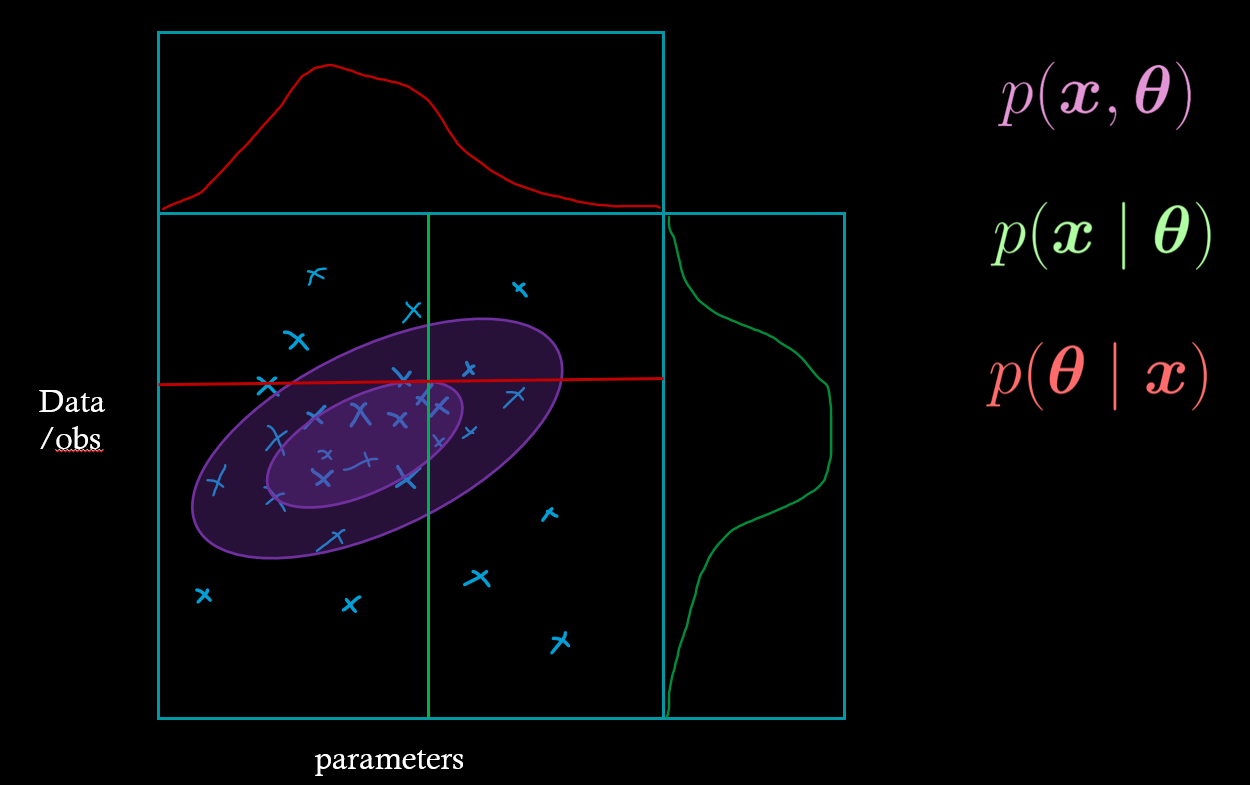

If I have run 2000 simulations I can evaluate the red curve, i.e. the posterior, at these positions. Then I can go and smooth this space with a kernel density estimation or fit a gaussian if I expect the posterior to be a gaussian. Then I will be ready to draw samples from this posterior, either by MCMC or by inverse transform sampling or anything else suitable. 

---

Now we will calculate the [f_i(x), y_i, sigma_i] and group them together

We have 19 points from xHI and 13 from UVLFs (because we take just the bright end with $M_{UV}<-17$)

In [244]:
# Get all uvlf data and save them in an array  in a cleaner(maybe) way
uvlf_x_obs = [[],[],[]] # Different sub_lists for different redshifts
uvlf_y_obs = []
uvlf_sigma_obs = []

for qq, redshift in enumerate([6,7,8]):
    fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(redshift)

    datainput = np.loadtxt(fLF)
    Muvs_obs = datainput[::2,0]
    phi_obs = datainput[::2,1]
    phi_err_obs = datainput[::2,2]
    
    for i in range(len(Muvs_obs)):
        if Muvs_obs[i]>-23 and Muvs_obs[i]<-17:
            uvlf_x_obs[qq].append(Muvs_obs[i])
            uvlf_y_obs.append(phi_obs[i])
            uvlf_sigma_obs.append(phi_err_obs[i])
            
obs_array = np.array([uvlf_y_obs,uvlf_sigma_obs])


print(obs_array)
uvlf_x_obs

[[2.000000e-04 7.000000e-04 3.600000e-03 7.100000e-03 1.000000e-06
  4.800000e-05 3.090000e-04 9.070000e-04 5.840000e-03 5.000000e-06
  5.800000e-05 3.310000e-04 1.060000e-03]
 [1.950641e-04 4.000000e-04 9.000000e-04 1.400000e-03 1.550806e-06
  1.500000e-05 6.100000e-05 1.770000e-04 1.460000e-03 3.000000e-06
  1.500000e-05 1.040000e-04 3.400000e-04]]


[[-20.75, -19.75, -18.75, -17.75],
 [-22.16, -21.16, -20.16, -19.16, -17.91],
 [-21.87, -20.87, -19.87, -18.62]]

Text(0.5, 1.0, 'All data from different redshifts in one plot')

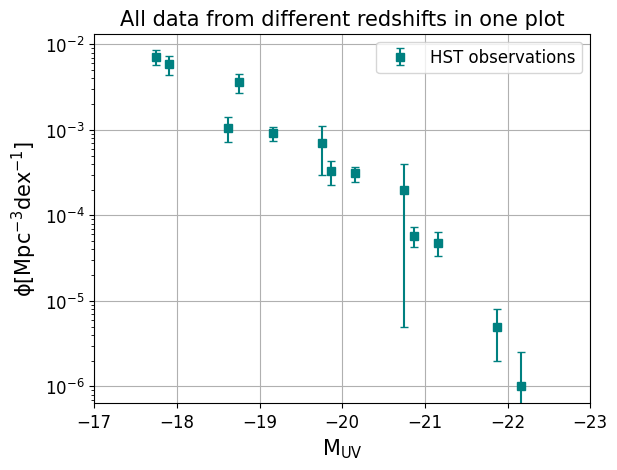

In [245]:
def flatten(xss):
    return [x for xs in xss for x in xs]
# Let's plot all of the data in the same plot
plt.errorbar(flatten(uvlf_x_obs), obs_array[0], yerr=obs_array[1], fmt='s', color='teal', label='HST observations',capsize=3)
plt.yscale('log')
plt.legend()
plt.xlim([-17,-23])
plt.grid()
plt.xlabel(r'$\rm M_{\rm UV}$')
plt.ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$");
plt.title(label= 'All data from different redshifts in one plot')

Our simulated data are binned and so they are discrete. We want the Muvs of our simulated data to corresponf to the Muvs of the observed ones. This doesn't matter so much but we can either (1) specify the Muv fist and then count how many halos are in a bin surrounding that Muv or (2) calculate a simulated binned UVLF and then interpolate. Here we do the second approach. One can either use nearest neighbors or linear interpolation or even higher order ones like spline etc.

In [289]:
def interpolate_obs_and_sims(x_obs, x_simed, y_simed, interpolation_type = 'NN'):
    '''
    Interpolates observed ans simualted data so that they characterize the same x values.
    
    Inputs (arrays or lists):
    - x_obs: observed positions
    - x_simed: simulated positions
    - y_simed: simulated quantities
    
    Returns (lists):
    - x_simed_corrected: Adjusted simulated x-values (matches x_obs for linear)
    - y_simed_corrected: Interpolated y-values for x_obs
    '''
    if interpolation_type == 'NN':
        x_simed_corrected = []
        y_simed_corrected = []
        for i in range(len(x_obs)):
            x_simed_corrected.append( x_simed[np.argmin(abs(x_simed-x_obs[i]))] )
            y_simed_corrected.append( y_simed[np.argmin(abs(x_simed-x_obs[i]))] ) 
            
    if interpolation_type == 'linear':
        x_simed_corrected = []
        y_simed_corrected = []
        for i in range(len(x_obs)):
            simed_id_closest = np.argmin(abs(x_simed-x_obs[i]))
            # Create fake array and make the minimum value large
            x_simed_second_closest = x_simed.copy()
            x_simed_second_closest[simed_id_closest] = 500
            simed_id_second_closest = np.argmin(abs(x_simed_second_closest-x_obs[i]))
            
            
            interpolated_y_simed = np.interp(x_obs[i], 
                      [ x_simed[simed_id_closest],x_simed[simed_id_second_closest] ], 
                      [ y_simed[simed_id_closest],y_simed[simed_id_second_closest] ])
            
            x_simed_corrected.append( x_obs[i] )
            y_simed_corrected.append(interpolated_y_simed)
       
    return x_simed_corrected, y_simed_corrected

In [283]:
# Loop through differend redshifts and create the same set like uvlf_x_obs but now uvlf_x_simed and obs_array but now simed_array

uvlf_x_simed = [[],[],[]] # Different sub_lists for different redshifts
uvlf_y_simed = []

for qq, redshift in enumerate([6,7,8]):
    Muv, phi = d_utils.get_uvlf(redshift, hdf)
    uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
    uvlf_y_simed+=uvlf_y_simed_qq

# obs_array = np.array([uvlf_y_obs,uvlf_sigma_obs])

Text(0.5, 1.0, 'All data from different redshifts in one plot')

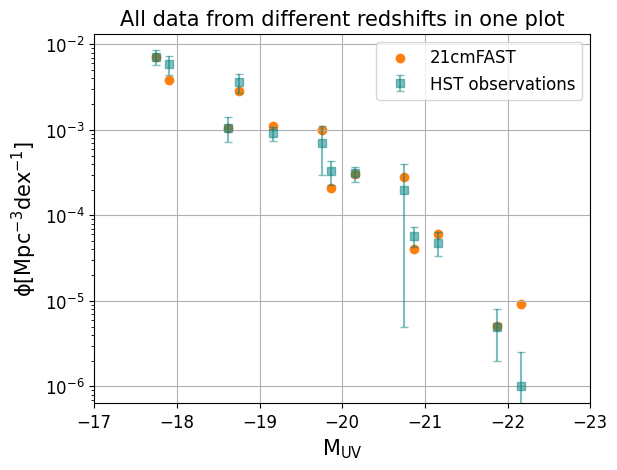

In [284]:
def flatten(xss):
    return [x for xs in xss for x in xs]
# Let's plot all of the data in the same plot
plt.errorbar(flatten(uvlf_x_obs), obs_array[0], yerr=obs_array[1], fmt='s', color='teal', label='HST observations',capsize=3, alpha=0.5)
plt.scatter(flatten(uvlf_x_simed), uvlf_y_simed, color='tab:orange', label='21cmFAST')
plt.yscale('log')
plt.legend()
plt.xlim([-17,-23])
plt.grid()
plt.xlabel(r'$\rm M_{\rm UV}$')
plt.ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$");
plt.title(label= 'All data from different redshifts in one plot')

## Same for XHI

In [290]:
# Find the corresponding Muvs and so the corresponding phis

yxg_eor_z_arr =   [5.0, 5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0,  10.5,  11.0,  11.5,  12.0,  12.5,  13.0,  13.5, 14.0]
yxg_eor_xhi_arr = [0.0, 0.02, 0.1, 0.24, 0.38, 0.45, 0.57, 0.65, 0.73, 0.79, 0.82,  0.89,  0.91,  0.93,  0.96,  0.98,  0.99,  0.99,  1.0]

x_HI_coev = hdf['coeval_data']['x_HI'][:]
node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']

# uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
simed_eor_z_arr, simed_eor_xhi_arr = interpolate_obs_and_sims(yxg_eor_z_arr[::-1], node_redshifts, x_HI_coev , 'linear')

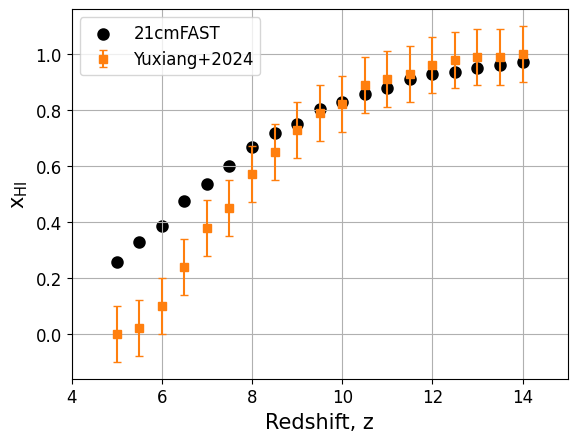

In [291]:
fig, ax = plt.subplots()
ax.errorbar(yxg_eor_z_arr,yxg_eor_xhi_arr, yerr = 0.1, fmt='s', capsize=3, color='tab:orange', label= 'Yuxiang+2024')
ax.scatter(simed_eor_z_arr, simed_eor_xhi_arr, color='black', label='21cmFAST', linewidth = 3)
ax.set_xlabel('Redshift, z')
ax.set_ylabel(r'$\rm x_{HI}$')
plt.grid()


ax.set_xlim([4,15])

ax.legend()
plt.show()

### Combine everything in a master array and compute $\chi^2$

In [302]:
# Get observed y and sigmas
y_obs = uvlf_y_obs+yxg_eor_xhi_arr
sigma_obs = uvlf_sigma_obs+list(np.ones(len(yxg_eor_xhi_arr))*0.1)

In [334]:
# Get simulated y (i.e. f)
def comlute_simuated_observables(file_id):
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{file_id}.h5', 'r')

    uvlf_x_simed = [[],[],[]] # Different sub_lists for different redshifts
    uvlf_y_simed = []

    for qq, redshift in enumerate([6,7,8]):
        Muv, phi = d_utils.get_uvlf(redshift, hdf)
        uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
        uvlf_y_simed+=uvlf_y_simed_qq

    x_HI_coev = hdf['coeval_data']['x_HI'][:]
    node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']

    # uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
    simed_eor_z_arr, simed_eor_xhi_arr = interpolate_obs_and_sims(yxg_eor_z_arr, node_redshifts, x_HI_coev , 'linear')

    y_simed = uvlf_y_simed+simed_eor_xhi_arr
    
    return y_simed

y_simed = comlute_simuated_observables(21)

In [340]:
def compute_chi2(y_obs, sigma_obs, y_simed):
    chi2 = 0
    for i in range(len(y_obs)):
        chi2 += (y_obs[i] - y_simed[i])**2 / sigma_obs[i]**2
    return chi2

chi2 = compute_chi2(y_obs, sigma_obs, y_simed)
chi2

72.07581885025047

In [341]:
def compute_chi2_likelihood(chi2):
    return np.exp(-chi2/2)

compute_chi2_likelihood(chi2)

2.2332369113613845e-16

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# GARBAGE

## Observed UVLFs Yuxiang

In [44]:
from astrodatapy.number_density import number_density
from astrodatapy.correlation    import correlation
from astrodatapy.clustering     import clustering

ImportError: cannot import name 'update_default_config' from 'astropy.config.configuration' (/home/ntriantafyllou/.conda/envs/21cm-dev4/lib/python3.11/site-packages/astropy/config/configuration.py)

Text(0.5, 1.0, 'z=6')

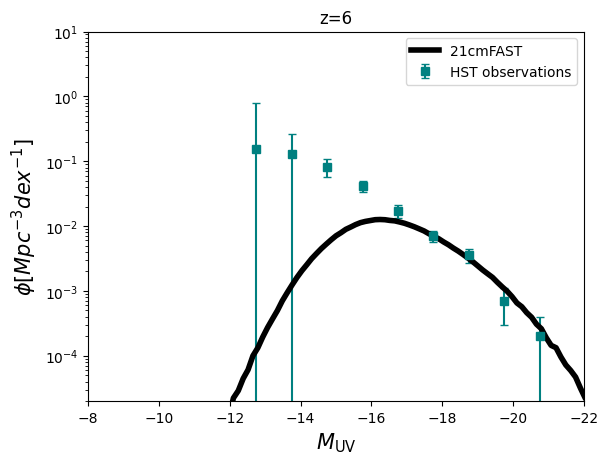

In [180]:
reload(d_utils)
# Let's plot the observations together with simulation results
which_redshift = 6
# Get observational data
fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(which_redshift)
datainput = np.loadtxt(fLF)

# Get simulation data
Muv, phi = d_utils.get_uvlf(which_redshift, hdf)


plt.errorbar(datainput[::2,0], datainput[::2,1], yerr=datainput[::2,2], fmt='s', color = 'teal',  capsize=3, label = 'HST observations')

plt.plot(Muv, phi, color='black', linewidth =4, label = '21cmFAST')


plt.yscale('log')
plt.xlim(Muv_limits[::-1])
plt.ylim(2e-5,10)
plt.xlabel(r'$M_{\rm UV}$',fontsize=15)
plt.ylabel(r"$\phi [Mpc^{-3} dex^{-1}]$",fontsize=15);
plt.legend()
plt.title(label= f'z={which_redshift}')
# axsLF[qq].xaxis.set_tick_params(labelsize=12)

In [246]:
def interpolate_obs_and_sims(x_obs, x_simed, y_simed, interpolation_type = 'NN'):
    '''
    Interpolates observed ans simualted data so that they characterize the same x values.
    
    Inputs (arrays or lists):
    - x_obs: observed positions
    - x_simed: simulated positions
    - y_simed: simulated quantities
    
    Returns (lists):
    - x_simed_corrected: Adjusted simulated x-values (matches x_obs for linear)
    - y_simed_corrected: Interpolated y-values for x_obs
    '''
    if interpolation_type == 'NN':
        x_simed_corrected = []
        y_simed_corrected = []
        for i in range(len(x_obs)):
            x_simed_corrected.append( x_simed[np.argmin(abs(x_simed-x_obs[i]))] )
            y_simed_corrected.append( y_simed[np.argmin(abs(x_simed-x_obs[i]))] ) 
            
    elif interpolation_type == 'linear':
        y_simed_corrected = list(np.interp(x_obs, x_simed, y_simed))
        x_simed_corrected = x_obs  # Linear interpolation already gives x_obs points
    
    else:
        raise ValueError("interpolation_type must be 'NN' or 'linear'")
        
    return x_simed_corrected, y_simed_corrected